In [1]:
import numpy as np
import scipy as sp
import matplotlib.pylab as plt
from scipy.stats import norm
from scipy.spatial import distance
from matplotlib import colors
import scipy as sp
from scipy.integrate import odeint,quad,simps
from scipy.special import eval_hermite,eval_hermitenorm,erfc
from math import sqrt,sin,pi,cos,exp,log,factorial

# Estimation of the operator $\mathcal{L}$

### 0. Data Simulation Euler–Maruyama method
$$dX_t = -X_t dt + \sqrt{2D}dW_t$$


In [2]:
def sim_sde(D=1,n=100000,dt = 0.0001):

    W = np.random.normal(loc=0,scale=np.sqrt(dt),size=(n,2))

    Z = np.zeros((n,2))
    Z[0,...] = 0
    for i in range(1,n):
        Z_1 = Z[i-1,...]
        Z[i,...] = Z_1 - Z_1*dt + np.sqrt(2*D) * W[i,:]
    return(Z)

In [128]:
# n = 2000000
# dt = 5e-5

n = int(2e4)
dt = 5e-3
T = n*dt
D = 1
# X = sim_sde(D=D,n=n,dt=dt)
X = np.random.normal(0,np.sqrt(D),size=(n,2))

In [132]:
# N = 5000
N = 5000
X_s = X[np.random.choice(range(n),size=N),:]

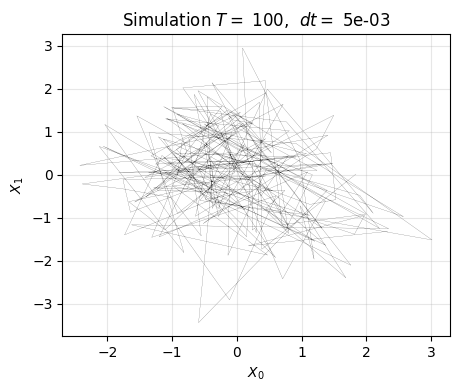

In [133]:
_ = plt.figure(figsize=(5,4),dpi=100)
_ = plt.plot(X[::100,0],X[::100,1],lw=0.1,color='k',zorder=1)
_ = plt.grid(alpha=0.3)
_ = plt.xlabel("$X_0$")
_ = plt.ylabel("$X_1$")
_ = plt.title(f"Simulation $T=$ {n*dt:.0f},  $dt =$ {dt:.0e}")

### 1. Compute an estimation of the invariant distribution of $\{x_i\}_{i=1}^{N}$, we denote it by $\hat{\rho}_{\text{eq}}$, we can do it by a non-parametric method such as kernel estimation

$$\rho_\infty (x,y)=\dfrac{1}{2\pi D} \exp\left(\frac{-(x^2 + y^2)}{2D} \right)$$

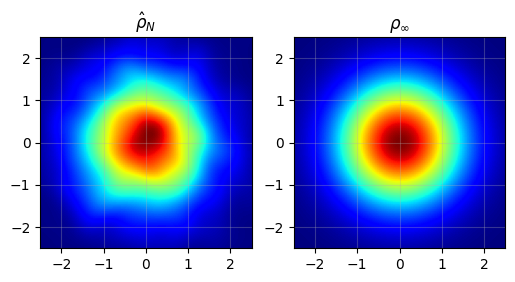

In [135]:
g_kde  = sp.stats.gaussian_kde(X_s.T)
def rho_inf(x,y,D):
    norm = x**2 + y**2
    frac = 1 / 2*pi*D
    expo = np.exp(-(x**2+y**2)/(2*D))
    return frac * expo
x = np.linspace(-2.5, 2.5, 120)
y = np.linspace(-2.5, 2.5, 120)
r1 = np.zeros((120,120))
for i,_x in enumerate(x):
    for j,_y in enumerate(x):
        r1[i,j] = g_kde([_x,_y])[0]
X1, X2 = np.meshgrid(x, y)
r2 =rho_inf(X1,X2,D)

fig,axs = plt.subplots(1,2,figsize=(6,3),dpi=100)
axs[0].imshow(r1,extent=[-2.5,2.5,-2.5,2.5],cmap='jet')
axs[0].set_title("$\\hat{\\rho}_N$")
axs[0].grid(alpha=0.3)

axs[1].imshow(r2,extent=[-2.5,2.5,-2.5,2.5],cmap='jet')
axs[1].set_title("$\\rho_{\infty}$")
axs[1].grid(alpha=0.3)

In [136]:
rho_eq = lambda x: g_kde(x)
p_invariant = rho_inf

### 2. Compute an estimate $\rho = \hat{\rho}_{\text{eq}}^{-1/2}$

In [137]:
rho = lambda x:rho_eq(x)**(-0.5)
Rho = rho(X_s.T).reshape(1,N)

### 3. Estimate $\epsilon$ computing $T(\epsilon) =\frac{1}{N}\sum_{i,j=1}^N K_\epsilon(x_i,x_j)$ and the derivatives to compute $$\epsilon = \text{argmax}_\epsilon \frac{\log(T(\epsilon + h) - \log(T(\epsilon))}{\log(\epsilon+h) - \log(\epsilon)}$$

In [138]:
Norm = -distance.squareform(distance.pdist(X_s, 'sqeuclidean'))/(4 *(Rho.T @ Rho))

In [139]:
h = 1e-6 #Small perturbation for T 
T = lambda epsilon : (1/N**2)*np.exp(Norm / epsilon).sum()
val = []

for l in np.linspace(-20,2): #evaluate for valyes from 2^-30 to 2 
    e = 2**l
    val.append((log(T(h+e)) - log(T(e))) / (log(e+h) - log(e)))

epsilon = 2 **np.linspace(-20,2)[np.argmax(val)]
epsilon

0.0016716751121010345

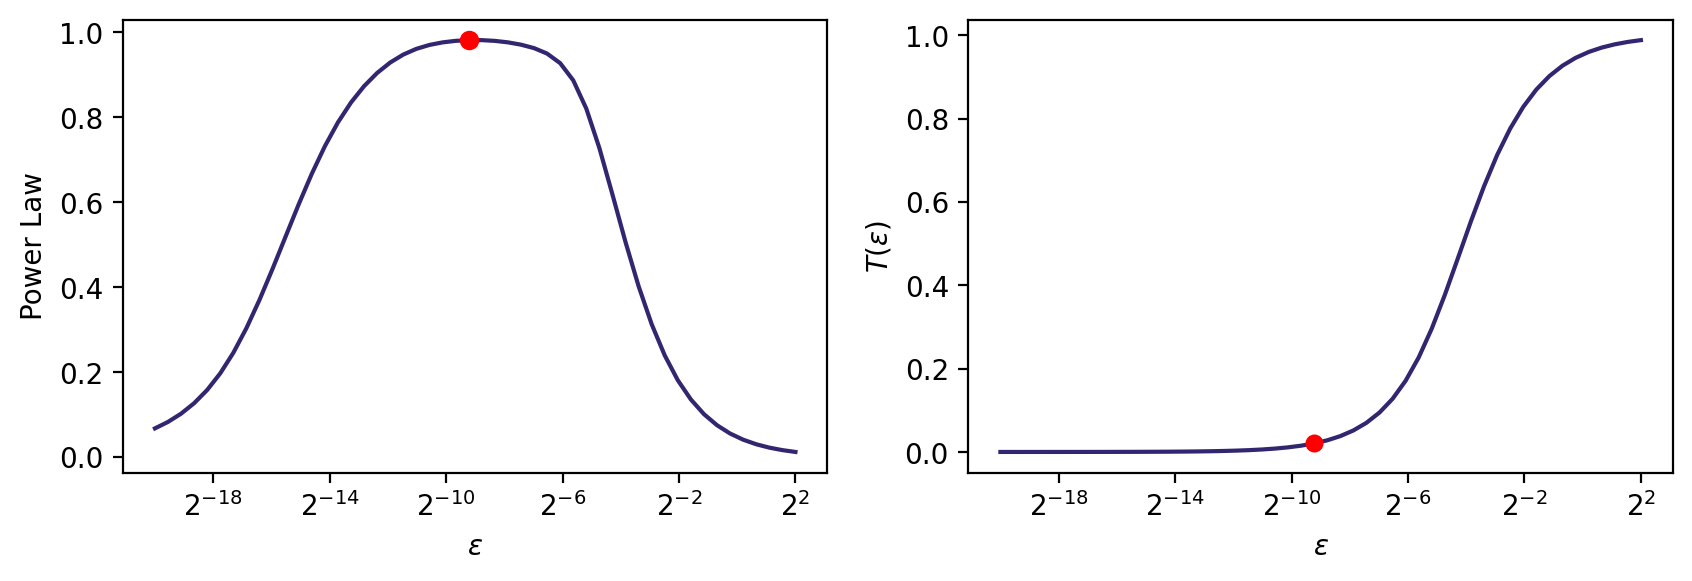

In [140]:
fig,axs = plt.subplots(1,2,figsize=(10,3),dpi=200)

axs[0].plot(2**np.linspace(-20,2),val,zorder=1,color='#322671')
axs[0].scatter(epsilon,max(val),color='red',zorder=2)

axs[0].set_xlabel('$\epsilon$')
axs[0].set_ylabel('Power Law')
axs[0].set_xscale('log',base=2)

axs[1].plot(2**np.linspace(-20,2), [T(2**l) for l in np.linspace(-20,2)],zorder=1,color='#322671')
axs[1].scatter(epsilon,T(epsilon),s=30,color='red',zorder=2)
axs[1].set_xlabel('$\epsilon$')
axs[1].set_ylabel('$T(\epsilon)$')
axs[1].set_xscale('log',base=2)

### 4. Compute the intrinsic dimension $d$ of the maifold $\mathcal{M}$ given by the data $\{x_i\}_{i=1}^{N}$, $d = 2\max_\epsilon \frac{\log(T(\epsilon + h) - \log(T(\epsilon))}{\log(\epsilon+h) - \log(\epsilon)}$

In [141]:
d = 2 * (log(T(h+epsilon)) - log(T(epsilon))) / (log(epsilon+h) - log(epsilon))
print(d)

1.9629995582861166


### 5. Compute the normalization kernel from the observations $$K_{\epsilon,\alpha}(x_i,x_j) = \frac{K_{\epsilon}(x_i,x_j)}{q_\epsilon(x_i)^\alpha q_\epsilon(x_j)^\alpha} $$ where $q_\epsilon(x) = \sum_{j=1}^N \frac{K_\epsilon(x,x_j)}{\rho(x)^d}$ and $\alpha = -d/4$

In [142]:
alpha = - d / 4
K_e = np.exp(Norm/epsilon)
q_e = (K_e.sum(axis=1) / (Rho ** d)).reshape(N,1)
K_e_a = K_e/((q_e**alpha)@ (q_e** alpha).T)

### 6. Construct a Markov matrix from $K_{\epsilon,\alpha}$ $$\hat{K}_{\epsilon,\alpha}(x_i,x_j) = \frac{K_{\epsilon,\alpha}(x_i,x_j)}{q_{\epsilon, \alpha}(x_i)}$$ where $q_{\epsilon, \alpha}(x)=\sum_{j=1}^{N} K_{\epsilon,\alpha}(x,x_j)$

In [143]:
K_e_a_hat = K_e_a/K_e_a.sum(axis=1)[:,None]

### 7. Compute the matrix estimation of $D^{-1}\mathcal{L}$, $L_\epsilon$ $$L_\epsilon(x_i,x_j) = \frac{\hat{K}_{\epsilon,\alpha}(x_i,x_j)-\delta_{ij}}{\epsilon \rho(x_i)^2} $$

In [144]:
L_e = np.zeros((N,N))
I = np.identity(N)
for i in range(N):
    L_e[:,i] = (K_e_a_hat[:,i] - I[:,i])/ (epsilon*(Rho**2))

### 8. Compute the eigenvalues and eigenvectors of $L_\epsilon$ to estimate the eigenvalues and eigenfunctions of $D^{-1}\mathcal{L}$: $\varphi_i,\lambda_i$. 

In [145]:
M = 1000
l, phi = sp.linalg.eigh(L_e,subset_by_index =(N-M,N-1),turbo=False)
l = l[::-1]
phi = phi[:,::-1]
phi = np.sqrt(N) * phi 

(-1.0, 2.0)

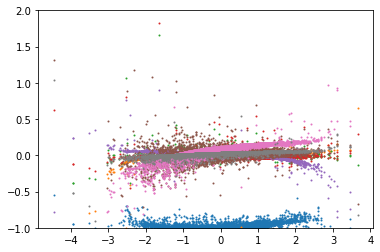

In [146]:
for j in range(8):
    plt.scatter(X_s[:,0],phi[:,j],s=1)
plt.ylim(-1,2)

\begin{align*}
\mathcal{L} f(x,y) &= -\frac{\partial}{\partial x} f(x,y)-\frac{\partial}{\partial y}f(x,y) + D\Delta f (x,y)
\end{align*}


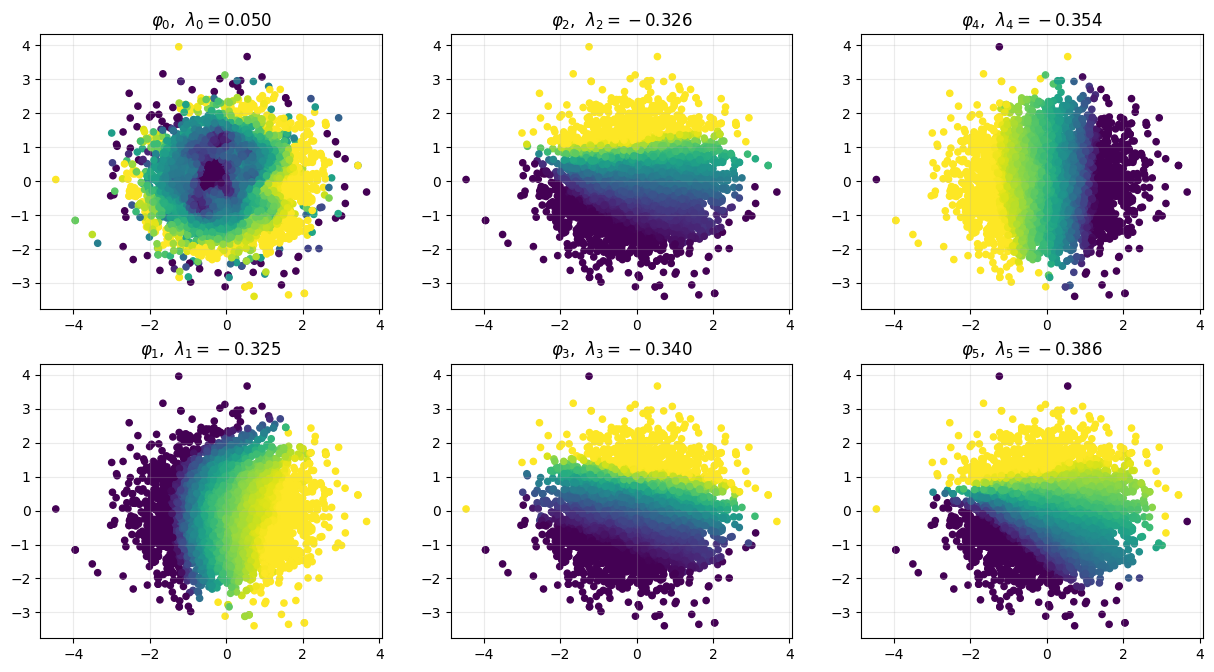

In [147]:
fig,axs = plt.subplots(2,3,figsize=(15,8),dpi=100)
for i,elle in enumerate(range(6)):
   
    axs[i%2,int(i / 2)].set_title(f"$\\varphi_{i}$,  $ \lambda_{i} = {l[i]:.3f}$")
    axs[i%2,int(i / 2)].scatter(X_s[:,0],X_s[:,1],s=20,c=phi[:,i],
                                norm = colors.Normalize(vmin=np.quantile(phi[:,i],0.1), vmax=np.quantile(phi[:,i],0.9)))
    axs[i%2,int(i / 2)].grid(alpha=0.25)

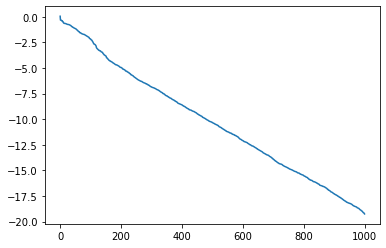

In [188]:
plt.plot(l)

$$f(x,y) = e^{-(x^2+y^2)}$$


\begin{align*}
\mathcal{L} f(x,y) &= 2x e^{-x^2 - y^2} +2y e^{-x^2 - y^2} + D(x^2 + y^2-1)(4 e^{-x^2 - y^2} )
\end{align*}

Text(0.5, 1.0, 'Analytic')

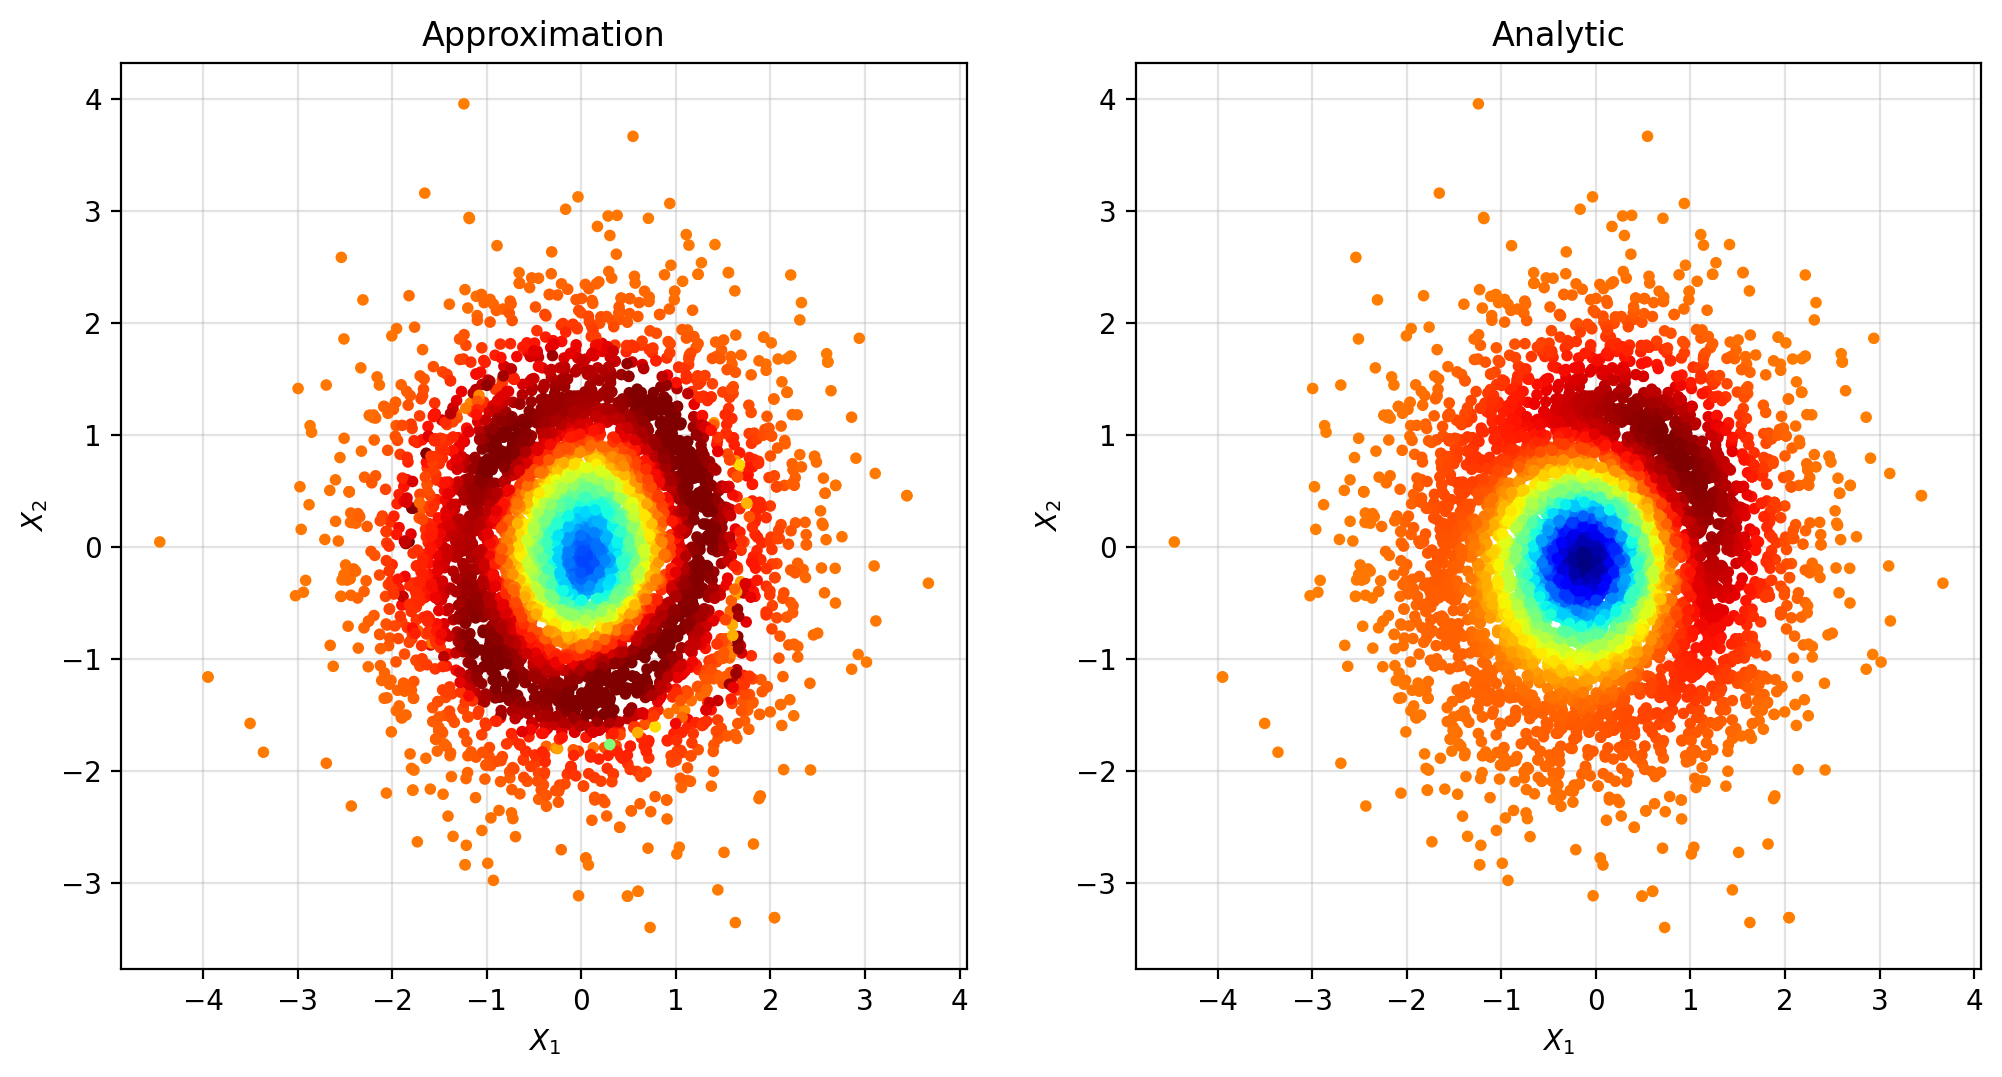

In [148]:
Lf = lambda x,y :np.exp(-x**2-y**2)* (2*x+2*y+4*D*(x**2+y**2-1))
fig,axs = plt.subplots(1,2,figsize=(12,6),dpi=200)
r3 = Lf(X1,X2)

Y = np.exp(-np.linalg.norm(X_s,axis=1)**2)
c_coef = (1/N) * (Y @ phi)

axs[0].scatter(X_s[:,0],X_s[:,1],s=10,c=np.sum((c_coef*l) * phi,axis=1),cmap='jet',
                                norm = colors.Normalize(vmin=np.min(r3), vmax=np.max(r3)),zorder=2)
axs[0].grid(alpha=0.35,zorder=1)
axs[0].set_xlabel('$X_1$')
axs[0].set_ylabel('$X_2$')
axs[0].set_title('Approximation')

axs[1].scatter(X_s[:,0],X_s[:,1],s=10,c=Lf(X_s[:,0],X_s[:,1]),cmap='jet',
                                norm = colors.Normalize(vmin=np.min(r3), vmax=np.max(r3)),zorder=2)
axs[1].grid(alpha=0.35,zorder=1)
axs[1].set_xlabel('$X_1$')
axs[1].set_ylabel('$X_2$')
axs[1].set_title('Analytic')
# axs[2].scatter(X_s[:,0],X_s[:,1],s=10,c=Lf(X_s[:,0],X_s[:,1]),cmap='jet',
#                norm = colors.Normalize(vmin=np.min(r3), vmax=np.max(r3)),zorder=2)
# axs[2].grid(alpha=0.35,zorder=1)
# plt.figure(figsize=(5.5,5))
# plt.scatter(X_s[:,0],X_s[:,1],c=np.abs(Lf(X_s[:,0],X_s[:,1]) -np.sum((c_coef*l) * phi,axis=1)),
#                norm = colors.Normalize(vmin=0, vmax=1),zorder=2,cmap='binary')

$$f(x,y) = \sin(x+y)$$


\begin{align*}
\mathcal{L} f(x,y) &= -2 \cos(x+y) - D \sin(x+y)
\end{align*}

Text(0.5, 1.0, 'Analytic')

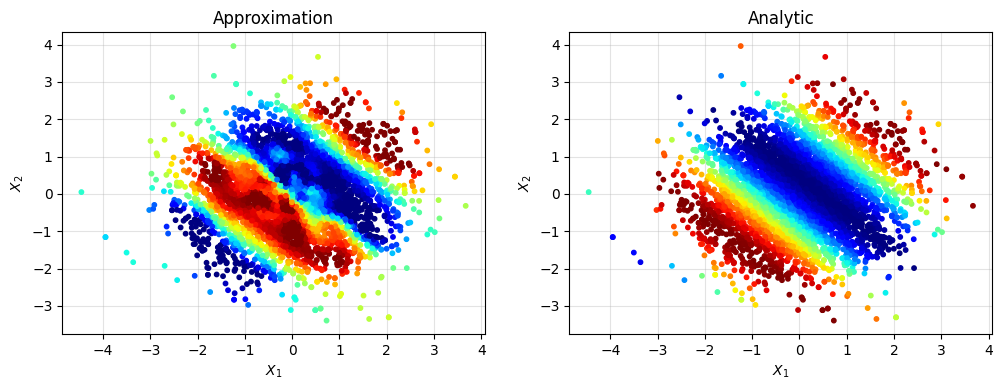

In [192]:
Lf = lambda x,y : -2*np.cos(x+y) - D*np.sin(x+y)
fig,axs = plt.subplots(1,2,figsize=(12,4),dpi=100)
r3 = Lf(X_s[:,0],X_s[:,1])

Y = np.sin(X_s[:,0] + X_s[:,1])
c_coef = D * (1/N) * (Y @ phi)

# axs[0].scatter(X_s[:,0],X_s[:,1],s=10,c=np.sum((c_coef*l) * phi,axis=1),cmap='jet',
#                                 norm = colors.Normalize(vmin=np.min(r3), vmax=np.max(r3)),zorder=2)

axs[0].scatter(X_s[:,0],X_s[:,1],s=10,c=L_e@Y,cmap='jet',
                                norm = colors.Normalize(vmin=np.min(r3), vmax=np.max(r3)),zorder=2)

axs[0].grid(alpha=0.35,zorder=1)
axs[0].set_xlabel('$X_1$')
axs[0].set_ylabel('$X_2$')
axs[0].set_title('Approximation')

axs[1].scatter(X_s[:,0],X_s[:,1],s=10,c=Lf(X_s[:,0],X_s[:,1]),cmap='jet',
                                norm = colors.Normalize(vmin=np.min(r3), vmax=np.max(r3)),zorder=2)
axs[1].grid(alpha=0.35,zorder=1)
axs[1].set_xlabel('$X_1$')
axs[1].set_ylabel('$X_2$')
axs[1].set_title('Analytic')

# axs[2].scatter(X_s[:,0],X_s[:,1],s=10,c=Lf(X_s[:,0],X_s[:,1]),cmap='jet',
#                norm = colors.Normalize(vmin=np.min(r3), vmax=np.max(r3)),zorder=2)
# axs[2].grid(alpha=0.35,zorder=1)
# plt.figure(figsize=(5.5,5))
# plt.scatter(X_s[:,0],X_s[:,1],c=np.abs(Lf(X_s[:,0],X_s[:,1]) -np.sum((c_coef*l) * phi,axis=1)),
#                norm = colors.Normalize(vmin=0, vmax=1),zorder=2,cmap='binary')

### 9. Compute a one dimensional observable $S$, for example $S(x(t)) = \sum_{i=1}^{n}((x(t))_i - \mathbb{E}((x(t))_i) $

In [ ]:
S = (X_s - X_s.mean())

### 10. Estimate the correlation time $$T_c = \int_{0}^{\infty} C(\tau)C(0)^{-1}d\tau \approx \text{(TR)}\int\frac{1}{T-j}\sum_{i=1}^{T-j}S(x_{i+j})S(x_i) $$

In [39]:
S = np.sum(X - X.mean(),axis=1)
n = len(S)
C_tau=np.zeros(n)
C0 = (1/n) * np.sum(S**2)
for j in range(1,n):
    if 1/(n-j)*sum(S[:n-j]*S[j:]) > 0:
        C_tau[j] = 1/(n-j)*sum(S[:n-j]*S[j:])
    else:
        break
C_tau = C_tau[C_tau>0]
pv = len(C_tau)
Tc = simps(x=np.linspace(0,n*dt,n)[:pv],y= C_tau / C0)

_ = plt.figure(figsize=(10,5),dpi=200)
_ = plt.grid(alpha=0.35)
_ = plt.plot(np.linspace(0,n*dt,n)[:pv],C_tau / C0 ,color='k',lw=2)
_ = plt.fill_between(np.linspace(0,n*dt,n)[:pv],C_tau / C0 ,color='k',lw=2,alpha=0.2)
_ = plt.xlabel('$\\tau$')
_ = plt.ylabel('$C(\\tau) C(0)^{-1}$')
_ = plt.title(f'$T_c = {Tc:.3f}$')

KeyboardInterrupt: 

 ### 11. Estimate D as $$D = -\frac{1}{T_c}\frac{\sum_{i=1}^M \lambda_i ^{-1}(S(x)^{\top}\varphi_i)^2}{\sum_{i=1}^M (S(x)^{\top}\varphi_i)^2} $$

In [ ]:
S = np.sum(X_s - X_s.mean(),axis=1)
s1 = np.sum((1/l) * (S.T@phi)**2)
s2 = np.sum((S.T@phi)**2)
D = - (1/Tc)* (s1/s2)
D

# Push-forward of a initial density $p_0(x)$

### 1. Estimate the initial condition $c_i(0)$ as $$\hat{c}_i(0)=\frac{1}{N}\sum_{j=1}^N \frac{p_0(x_j)}{\hat{p}_{\text{eq}}(x_j)}\varphi_i(x_j) $$

In [ ]:
p_0 = np.vectorize(lambda x: (1/np.sqrt(2*pi))* np.exp((-(x-1)**2)/2) )
p_0 = np.vectorize(lambda x: sp.stats.norm.pdf(x,-2,0.3))
# p_0 = np.vectorize(lambda x: sp.stats.expon.pdf(x,1))

p_inf = np.vectorize(lambda x: (1/np.sqrt(2*pi))* np.exp((-(x)**2)/2) )
c_0 = (1/len(X_s)) * np.sum(((p_0(X_s)/rho_eq(X_s)))[:,None] * phi,axis=0)

### 2. Compute the numerical solution of the ODE $$\frac{\text{d} c}{\text{d} t} = D\Lambda c$$ with initial condition $\hat{c}_i(0)$

In [ ]:
Lambda = np.diag(l)
D = 1
def RHS(y,t):
    return((D*Lambda) @ y)

init = 0
tf = 5
Nt = 100
tarray = np.linspace(0,tf,Nt)

csol = odeint(RHS,c_0,tarray,args=())

### 3. Using $M$ modes estimate the density  as $$\hat{p}(x,t) =\hat{p}_{\text{eq}}(x) \sum_{i=0}^M \hat{c}_i(t)\varphi_i(x)$$

In [ ]:
_ = plt.figure(figsize=(7,4),dpi=100)
X_sort = np.sort(X_s)
N = len(X_s)
dx = np.diff(X_sort)
for t in [1,5,10,20,50,80,99]:
    est_density = np.zeros(N,)
    for i in range(N):
        est_density[i] = np.sum(csol[t] * phi[i,:] * rho_eq (X_s[i]))

    est_density=est_density[np.argsort(X_s)]
    cum = simps(x=X_sort,y= est_density)
    
    plt.plot(X_sort,(1/cum) *est_density,lw=1,color=plt.cm.plasma(t/100))
    
    
plt.plot(np.linspace(min(X_s),max(X_s),100),p_inf(np.linspace(min(X_s),max(X_s),100)),
         color='r',marker='x',ms=5,alpha=0.5)
plt.plot(np.linspace(min(X_s),max(X_s),100),p_0(np.linspace(min(X_s),max(X_s),100)),
         color='k',marker='x',ms=5,alpha=0.7)
    
plt.grid(alpha=0.3)

Approximation of the operator $\mathcal{L}^*$ using hermite polinomials

In [ ]:
N = 200
x = np.linspace(-3,3,N)
l_hermite_s, phi_hermite_s =  Hermite(k=20,x=x,D=D)
phi_hermite_s = p_invariant(x)[:,None] * phi_hermite_s
L_s = phi_hermite_s @ np.diag(l_hermite_s) @ np.linalg.pinv(phi_hermite_s)

In [ ]:
Y = np.exp(-x**2)
plt.scatter(x,L_s@Y,s=10,color='r')
plt.plot(x,np.exp(-x**2) + x*((-2*x)*np.exp(-x**2)) + (4*x**2-2)*np.exp(-x**2))


In [ ]:
def RHS(y,t):
    return(L_s @ y)

init = 0
tf = 5
Nt = 100
tarray = np.linspace(0,tf,Nt)

csol = odeint(RHS,p_0(x),tarray,args=())

In [ ]:
_ = plt.figure(figsize=(7,4),dpi=100)
for t in [0,1,5,10,20,50,80,99]:
    cum = simps(x=x,y= csol[t,:])

    _ = plt.plot(x,csol[t,:]/cum,color=plt.cm.plasma(t/100))
    
    
plt.plot(np.linspace(min(X_s),max(X_s),100),p_inf(np.linspace(min(X_s),max(X_s),100)),
         color='r',marker='x',ms=5,alpha=0.5)
plt.plot(np.linspace(min(X_s),max(X_s),100),p_0(np.linspace(min(X_s),max(X_s),100)),
         color='k',marker='x',ms=5,alpha=0.7)
plt.ylim(-0.1,1.6)
plt.grid(alpha=0.2)

Theoretical result
$$p(x,t) = \int \sqrt{\frac{1}{2\pi D(1-e^{-2t})}} \exp{\left(\frac{(x-x_0e^{-t})^2}{2D(1-e^{-2t}) } \right)}p_0(x_0)dx_0$$

In [ ]:
p_transition = lambda x0,x,t: sp.stats.norm.pdf(x,loc=x0*np.exp(-t),scale = 1-np.exp(-2*t))*p_0(x0)

In [ ]:
_ = plt.figure(figsize=(7,4),dpi=100)

for t in [0.1,0.5,1,2,5,10]:
    N = 100
    x = np.linspace(-3,3,N)
    x0 = np.linspace(-3,3,N)
    pxt = np.zeros_like(x)
    for i in range(N):
        pxt[i] = simps(x=x0,y=p_transition(x0,x[i],t))
    plt.plot(x,pxt)
    
    
plt.plot(np.linspace(min(X_s),max(X_s),100),p_inf(np.linspace(min(X_s),max(X_s),100)),
         color='r',marker='x',ms=5,alpha=0.5)
plt.plot(np.linspace(min(X_s),max(X_s),100),p_0(np.linspace(min(X_s),max(X_s),100)),
         color='k',marker='x',ms=5,alpha=0.7)
    
plt.grid(alpha=0.3)

# Push-forward of obserbable $f(x)$


In [ ]:
Lambda = np.diag(l)
D = 1
def RHS(y,t):
    return((D*Lambda) @ y)

init = 0
tf = 5
Nt = 100
tarray = np.linspace(0,tf,Nt)

csol = odeint(RHS,c_0,tarray,args=())

In [ ]:
for p in [1,2,3,4]:
    N = len(X_s)
    f = X_s**p
    a = (1/N)*(f @ phi)
    plt.plot(csol @ a)